In [3]:
from google.colab import drive

drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print(f'Found GPU at: {device_name}')


Found GPU at: /device:GPU:0


In [14]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# !pip install transformers[torch] datasets


from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments
import numpy as np
from datasets import Dataset
import pandas as pd
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

# Make sure to adjust paths and column names as per your dataset
df = pd.read_csv('/content/gdrive/MyDrive/data.csv')

# Preprocessing steps
df['ProcessedComments'] = df['ProcessedComments'].astype(str)
df['sentiment'] = df['sentiment'].map({-1: 0, 0: 1, 1: 2})
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

model_checkpoint = "distilroberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# def tokenize(batch):
#     return tokenizer(batch["ProcessedComments"], padding=True, truncation=True, max_length=512)

def tokenize(batch):
    return tokenizer(batch["ProcessedComments"], padding=True, truncation=True, max_length=512)



train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

train_dataset = train_dataset.rename_column("sentiment", "labels")
test_dataset = test_dataset.rename_column("sentiment", "labels")
train_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
test_dataset.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Loading the model and training
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")

# Then specify this data_collator in your Trainer

model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=3)

training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    per_device_train_batch_size=8,  # Adjust based on GPU memory
    per_device_eval_batch_size=8,
    learning_rate=5e-5,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
)

def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()


Map:   0%|          | 0/6800 [00:00<?, ? examples/s]

Map:   0%|          | 0/1700 [00:00<?, ? examples/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.720900,0.671445,0.800000,0.807693,0.800000,0.791637
2,0.428400,0.745634,0.817647,0.825476,0.817647,0.812263
3,0.323900,0.721231,0.833529,0.835209,0.833529,0.829809
4,0.256200,0.859944,0.837059,0.837781,0.837059,0.832446
5,0.182700,0.830657,0.839412,0.838763,0.839412,0.836497


Checkpoint destination directory ./results/checkpoint-850 already exists and is non-empty. Saving will proceed but saved results may be invalid.


TrainOutput(global_step=4250, training_loss=0.37033968308392695, metrics={'train_runtime': 1713.8849, 'train_samples_per_second': 19.838, 'train_steps_per_second': 2.48, 'total_flos': 4503334364091072.0, 'train_loss': 0.37033968308392695, 'epoch': 5.0})

Accuracy: 0.8000
Precision: 0.8077
Recall: 0.8000
F1-Score: 0.7916


[Text(0, 0.5, 'Negative (-1)'),
 Text(0, 1.5, 'Neutral (0)'),
 Text(0, 2.5, 'Positive (1)')]

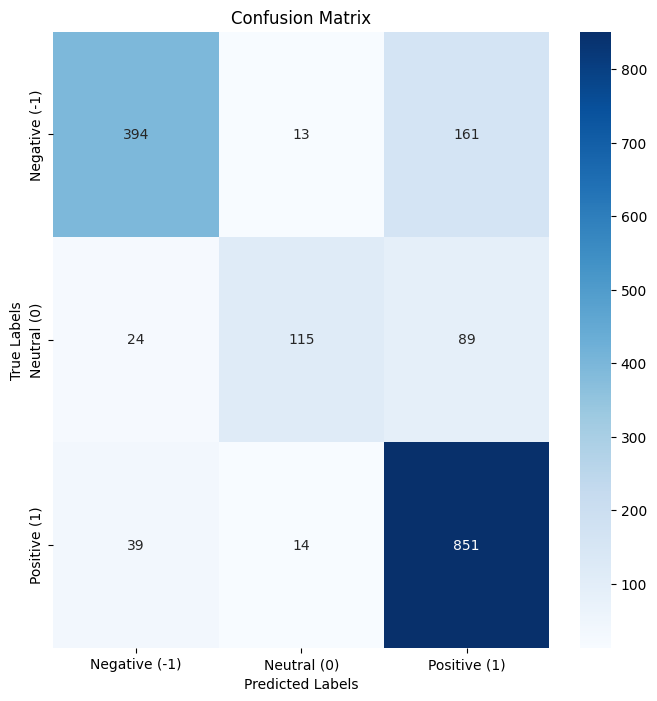

In [16]:
# Making predictions
predictions = trainer.predict(test_dataset)
preds = np.argmax(predictions.predictions, axis=-1)

from sklearn.metrics import accuracy_score, precision_recall_fscore_support

labels = predictions.label_ids
accuracy = accuracy_score(labels, preds)
precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(labels, preds)
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size as needed
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Negative (-1)', 'Neutral (0)', 'Positive (1)'])
ax.yaxis.set_ticklabels(['Negative (-1)', 'Neutral (0)', 'Positive (1)'])

